In [4]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Implement Niblack and Sauvola thresholding
def niblack(img, window_size=25, k=-0.2):
    h, w = img.shape
    pad = window_size // 2
    padded = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    threshold_map = np.zeros_like(img, dtype=np.float32)
    for i in range(h):
        for j in range(w):
            win = padded[i:i+window_size, j:j+window_size].astype(np.float32)
            mean = win.mean()
            std = win.std()
            threshold_map[i, j] = mean + k * std
    return threshold_map

def sauvola(img, window_size=25, k=0.2, r=128):
    h, w = img.shape
    pad = window_size // 2
    padded = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    threshold_map = np.zeros_like(img, dtype=np.float32)
    for i in range(h):
        for j in range(w):
            win = padded[i:i+window_size, j:j+window_size].astype(np.float32)
            mean = win.mean()
            std = win.std()
            threshold_map[i, j] = mean * (1 + k * (std / r - 1))
    return threshold_map

In [5]:
# Load dataset
base_path = Path('.')

train_imgs = [cv2.imread(str(p), 0) 
              for p in sorted((base_path / 'training' / 'images').glob('*.tif'))]

train_masks = [cv2.imread(str(p), 0) 
               for p in sorted((base_path / 'training' / 'mask').glob('*.gif'))]

train_manual = [cv2.imread(str(p), 0) 
                for p in sorted((base_path / 'training' / '1st_manual').glob('*.gif'))]

test_imgs = [cv2.imread(str(p), 0) 
             for p in sorted((base_path / 'test' / 'images').glob('*.tif'))]

test_masks = [cv2.imread(str(p), 0) 
              for p in sorted((base_path / 'test' / 'mask').glob('*.gif'))]

# ⭐ ADD THIS (THIS WAS MISSING)
test_manual = [cv2.imread(str(p), 0) 
               for p in sorted((base_path / 'test' / '1st_manual').glob('*.gif'))]

print(f"Loaded {len(train_imgs)} training, {len(test_imgs)} test images")

Loaded 20 training, 20 test images


In [6]:
# Preprocessing: Extract green channel + CLAHE
def preprocess(img, mask):

    # If RGB image → take green channel
    if len(img.shape) == 3:
        green = img[:, :, 1]
    else:
        green = img

    # CLAHE contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)

    return enhanced, mask

# Apply preprocessing
train_processed = [preprocess(img, m) for img, m in zip(train_imgs, train_masks)]
test_processed = [preprocess(img, m) for img, m in zip(test_imgs, test_masks)]

print(f"Preprocessing complete: {train_processed[0][0].shape}")

Preprocessing complete: (584, 565)


In [7]:
# Apply Niblack and Sauvola thresholding
def apply_thresholding(img, window_size=25):

    nb_map = niblack(img.astype(np.uint8), window_size=window_size, k=-0.2)
    sv_map = sauvola(img.astype(np.uint8), window_size=window_size, k=0.2, r=128)

    # Convert threshold maps → binary vessel masks
    nb_bin = (img > nb_map).astype(np.uint8) * 255
    sv_bin = (img > sv_map).astype(np.uint8) * 255

    return nb_bin, sv_bin

# Test on first image
test_img, test_mask = test_processed[0]
niblack_result, sauvola_result = apply_thresholding(test_img)

print("Thresholding methods applied")

Thresholding methods applied


In [8]:
# Compute sensitivity metrics
def compute_sensitivity(binary_img, gt_vessels, mask):

    roi_binary = binary_img[mask > 0]
    roi_gt = (gt_vessels[mask > 0] > 128).astype(np.uint8)
    roi_pred = (roi_binary > 128).astype(np.uint8)

    tp = np.sum(roi_pred & roi_gt)
    fn = np.sum((1 - roi_pred) & roi_gt)

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = np.sum((1 - roi_pred) & (1 - roi_gt)) / np.sum(1 - roi_gt)

    return sensitivity, specificity


# ⭐ Evaluate on TRAINING SET (because manual labels exist here)
niblack_sens, sauvola_sens = [], []
niblack_spec, sauvola_spec = [], []

for i, (train_img, train_mask) in enumerate(train_processed):

    gt_vessels = train_manual[i]   # ← REAL ground truth

    niblack_bin, sauvola_bin = apply_thresholding(train_img)

    nb_sen, nb_spec = compute_sensitivity(niblack_bin, gt_vessels, train_mask)
    sv_sen, sv_spec = compute_sensitivity(sauvola_bin, gt_vessels, train_mask)

    niblack_sens.append(nb_sen)
    niblack_spec.append(nb_spec)

    sauvola_sens.append(sv_sen)
    sauvola_spec.append(sv_spec)


print(f"Niblack - Sensitivity: {np.mean(niblack_sens):.4f} ± {np.std(niblack_sens):.4f}")
print(f"Sauvola - Sensitivity: {np.mean(sauvola_sens):.4f} ± {np.std(sauvola_sens):.4f}")

print(f"\nNiblack - Specificity: {np.mean(niblack_spec):.4f} ± {np.std(niblack_spec):.4f}")
print(f"Sauvola - Specificity: {np.mean(sauvola_spec):.4f} ± {np.std(sauvola_spec):.4f}")

Niblack - Sensitivity: 0.1942 ± 0.0304
Sauvola - Sensitivity: 0.5969 ± 0.0689

Niblack - Specificity: 0.2637 ± 0.0209
Sauvola - Specificity: 0.0176 ± 0.0081


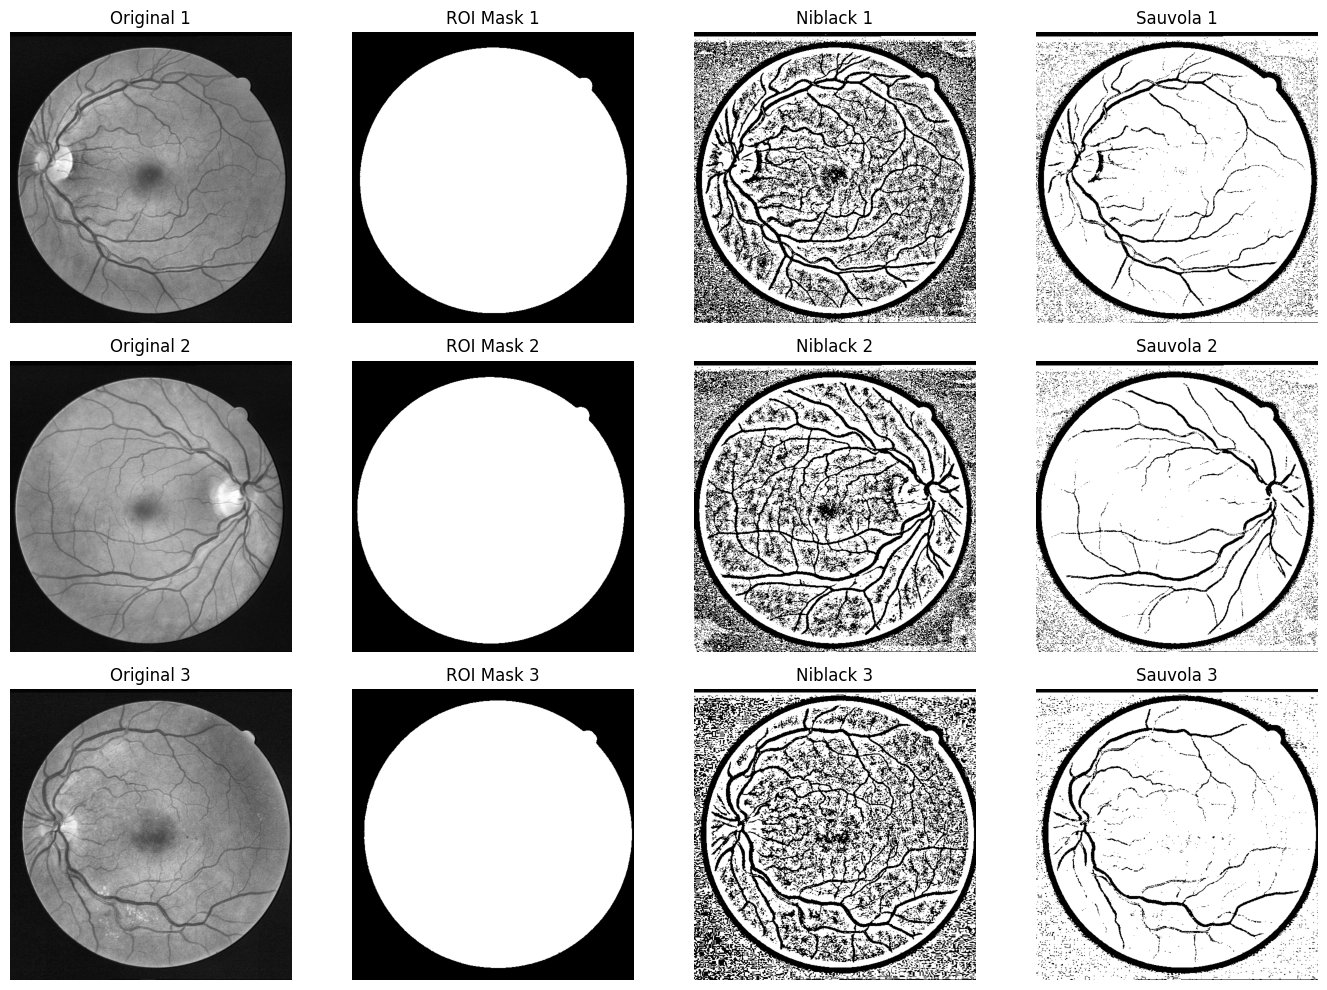

Visualization saved as 'vessel_extraction_comparison.png'


In [9]:
# Visualization: Compare results on sample images

num_samples = min(3, len(test_processed))   # safety check

fig, axes = plt.subplots(num_samples, 4, figsize=(14, 10))

for idx in range(num_samples):

    test_img, test_mask = test_processed[idx]

    # Apply thresholding (mask not needed here)
    niblack_bin, sauvola_bin = apply_thresholding(test_img)

    axes[idx, 0].imshow(test_img, cmap='gray')
    axes[idx, 0].set_title(f'Original {idx+1}')

    axes[idx, 1].imshow(test_mask, cmap='gray')
    axes[idx, 1].set_title(f'ROI Mask {idx+1}')

    axes[idx, 2].imshow(niblack_bin, cmap='gray')
    axes[idx, 2].set_title(f'Niblack {idx+1}')

    axes[idx, 3].imshow(sauvola_bin, cmap='gray')
    axes[idx, 3].set_title(f'Sauvola {idx+1}')

    for ax in axes[idx]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('vessel_extraction_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("Visualization saved as 'vessel_extraction_comparison.png'")

In [10]:
# Summary: Method Comparison

print("="*60)
print("RETINAL VESSEL EXTRACTION: NIBLACK vs SAUVOLA")
print("="*60)

# Pre-calculate metrics (cleaner + faster)
nb_mean_sen = np.mean(niblack_sens)
sv_mean_sen = np.mean(sauvola_sens)

nb_std_sen = np.std(niblack_sens)
sv_std_sen = np.std(sauvola_sens)

nb_mean_spec = np.mean(niblack_spec)
sv_mean_spec = np.mean(sauvola_spec)

nb_std_spec = np.std(niblack_spec)
sv_std_spec = np.std(sauvola_spec)

print(f"\n{'Metric':<20} {'Niblack':<20} {'Sauvola':<20}")
print("-"*60)
print(f"{'Mean Sensitivity':<20} {nb_mean_sen:<20.4f} {sv_mean_sen:<20.4f}")
print(f"{'Std Sensitivity':<20} {nb_std_sen:<20.4f} {sv_std_sen:<20.4f}")
print(f"{'Mean Specificity':<20} {nb_mean_spec:<20.4f} {sv_mean_spec:<20.4f}")
print(f"{'Std Specificity':<20} {nb_std_spec:<20.4f} {sv_std_spec:<20.4f}")

winner = "Sauvola" if sv_mean_sen > nb_mean_sen else "Niblack"

print(f"\n✓ Best method for thin vessel detection: {winner}")
print(f"  Sensitivity advantage: {abs(sv_mean_sen - nb_mean_sen):.4f}")

RETINAL VESSEL EXTRACTION: NIBLACK vs SAUVOLA

Metric               Niblack              Sauvola             
------------------------------------------------------------
Mean Sensitivity     0.1942               0.5969              
Std Sensitivity      0.0304               0.0689              
Mean Specificity     0.2637               0.0176              
Std Specificity      0.0209               0.0081              

✓ Best method for thin vessel detection: Sauvola
  Sensitivity advantage: 0.4028
